# P000456CSITCP - Hate Speech Detection

*This will be a summary of the entire jupyternotebook* I will do this at the end :)

In [2]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Loading The Dataset 

- The twitter.csv file is loaded into the variable name data. This is then used to condut initial analysis onthe data.
- The variables on this csv file are unamed, count, hate_speech, offensive_language, neither and class. 

Below is a list explaining each variable 
- count: The total number of annotations for each tweet. (Integer) </br>
- hate_speech: The number of annotations classifying a tweet as hate speech. (Integer)</br>
- offensive_language_count: The number of annotations classifying a tweet as offensive language. (Integer)</br>
- neither_count: The number of annotations classifying a tweet as neither hate speech nor offensive language. (Integer)</br>
- class: The level of hate in which the twitter comment is projecting; hate speech, offensive language or neither. (Integer) </br>
- tweet: The tweet which the classfications are being made (String) </br>

NOTE: The Unnamed column looks to be an index column.

In [3]:
# Load the data
data = pd.read_csv('twitter.csv')

# Display the first 5 rows of the data
print(data.head())


   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


In [4]:
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

To really understand the level of hate in which the dataset entials the class variable in looked into further. It can be said that 'class' 1 has the most counts followed by 'class' 2 then 3. 

The class column indicates 
- 0: Hate Speech 
- 1: Offesnive Language
- 2: Neither 

In [5]:
data.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


Looking at the statistical analysis of each variable (excluding count and unamed) it can be said that:

- hate_speech: With a mean of 0.28 it can be said that most entries have low levels of hate_speech and thus most likely not being classified as hate speech. Aditionally with a 0.0 distibrution for the 25, 50 and 75 percentile show no hate speech in the data points. With a max of 7 it can highlight some entires of high levels of hate speech 

- offesnive_language: A mean of 2.41 shows a higher average than hate_speech and can therefore be said that offensive language is more common than hate speech. It can be noted that half of the data had a score of 3 or lower for offensive langauge. Some entires also show high levels of offensive language with a max value of 9. 

- neither: The mean od 0.55 shows a good portion of the data is neither hate speech or offensive language. Aditionally with a 0.0 distibrution for the 25, 50 and 75 percentile show that the data falls into other categories. Some entires also show high levels of neither category with a max value of 9. 

- class: 1.11 mean shows most enties are classified as offensive langauge (1). This can be shown with the 25th and 50th percentiles being 1. The max value of 2 shows that hate speech is present but less common. 

Ultimately the data is skewed towards offensive language. A larger proportion of the data can be seen to be offensive language as seen by the class in comparison to hate speech and a small group within neither.

In [6]:
data.isna().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [7]:
data.duplicated().sum()

0

It can also be seen that there are no n/a data within any of the variables and no duplicated data in the dataset as well. 

<AxesSubplot:xlabel='class', ylabel='Count'>

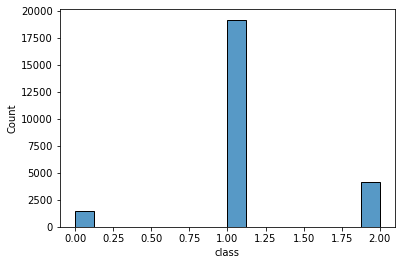

In [8]:
# plot the distribution of the classes
sns.histplot(data['class'])


Looking at the histogram it can be reinstated that the offensive langauge category is classfied heavily in the dataset followed by approximately 25% of the data classfied as neither and hate speech.

# for team - should we add in TwitterHate.csv to help balance our classes here?

## Data Processing

- The data preprocessing stage is important to turn the raw data (twitter.csv) into clean data that can then be used for training and testing. 

The next steps that must be taken after the intial data analysis is data preprocessing. Here the dataset is taken and the following elements are removed from the dataset: 

- urls
- usernames (especially for anonymity)
- emojis
- punctuation
- single characters + double spaces

The following are processed to ensure clarity in the data:

- Turning everything lowercase

In [9]:
data_processed=data[['tweet','class']]
data_processed.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [10]:
# remove the urls
data_processed["tweet"] = data_processed["tweet"].apply(lambda x:re.sub(r'https?://\S+', '', str(x)))
data_processed["tweet"]


/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/2544297350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed["tweet"] = data_processed["tweet"].apply(lambda x:re.sub(r'https?://\S+', '', str(x)))


0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [11]:
# Lowercase removal
data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data_processed['tweet']

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/1831671013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))


0        !!! rt @mayasolovely: as a woman you shouldn't...
1        !!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3        !!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4        !!!!!!!!!!!!! rt @shenikaroberts: the shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@lifeasking: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like i ain...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: tweet, Length: 24783, dtype: object

In [12]:
# Punctuation Removal
data_processed['tweet'] = data_processed['tweet'].str.replace('[^\w\s]','')
data_processed['tweet']

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/2353336898.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data_processed['tweet'] = data_processed['tweet'].str.replace('[^\w\s]','')
/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/2353336898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].str.replace('[^\w\s]','')


0         rt mayasolovely as a woman you shouldnt compl...
1         rt mleew17 boy dats coldtyga dwn bad for cuff...
2         rt urkindofbrand dawg rt 80sbaby4life you eve...
3         rt c_g_anderson viva_based she look like a tr...
4         rt shenikaroberts the shit you hear about me ...
                               ...                        
24778    yous a muthafin lie 8220lifeasking 20_pearls c...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [13]:
# Single character and double space removal (a/i/n etc)
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
data_processed['tweet'] 

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/3867049835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))


0         rt mayasolovely as woman you shouldnt complai...
1         rt mleew17 boy dats coldtyga dwn bad for cuff...
2         rt urkindofbrand dawg rt 80sbaby4life you eve...
3          rt c_g_anderson viva_based she look like tranny
4         rt shenikaroberts the shit you hear about me ...
                               ...                        
24778    yous muthafin lie 8220lifeasking 20_pearls cor...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [14]:
# remove usernames/handles 
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'@\w+', '', x))
data_processed['tweet']

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/3113575936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'@\w+', '', x))


0         rt mayasolovely as woman you shouldnt complai...
1         rt mleew17 boy dats coldtyga dwn bad for cuff...
2         rt urkindofbrand dawg rt 80sbaby4life you eve...
3          rt c_g_anderson viva_based she look like tranny
4         rt shenikaroberts the shit you hear about me ...
                               ...                        
24778    yous muthafin lie 8220lifeasking 20_pearls cor...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [15]:
# remove emojis
data_processed['tweet'] = data_processed['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
data_processed['tweet']

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/643837315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))


0         rt mayasolovely as woman you shouldnt complai...
1         rt mleew17 boy dats coldtyga dwn bad for cuff...
2         rt urkindofbrand dawg rt 80sbaby4life you eve...
3          rt c_g_anderson viva_based she look like tranny
4         rt shenikaroberts the shit you hear about me ...
                               ...                        
24778    yous muthafin lie 8220lifeasking 20_pearls cor...
24779    youve gone and broke the wrong heart baby and ...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

After removing emojis, usernames/handles, single charters, double spaces, punctuations, lowercases and URLs, the most common words are generated to understand what is the most common words amongst tweets. 

In [16]:
# Most common words
freq = pd.Series(' '.join(data_processed['tweet']).split()).value_counts()[:10]
freq


bitch      8120
rt         7578
the        7168
you        6075
to         5332
and        3950
my         3576
that       3515
in         3049
bitches    3045
dtype: int64

It can be noted that the words/symbols 'rt' and ':' are the most common among the tweets. These two words/symbols are of no benefit for this dataset and do not contribute to the analysis of hate speech. The term 'rt' is used in twitter to say retweet which is the action of re posting a twitter post and the semicolon, :, can be used for gramatical purposes. 

For this analysis, "rt" and the ":" symbol are not needed, so we can remove them as well. 

In [17]:
# remove the words rt and :
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'rt', '', x))
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r':', '', x))
data_processed['tweet']

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/48207569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'rt', '', x))
/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/48207569.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r':', '', x))


0          mayasolovely as woman you shouldnt complain ...
1          mleew17 boy dats coldtyga dwn bad for cuffin...
2          urkindofbrand dawg  80sbaby4life you ever fu...
3             c_g_anderson viva_based she look like tranny
4          shenikarobes the shit you hear about me migh...
                               ...                        
24778    yous muthafin lie 8220lifeasking 20_pearls cor...
24779    youve gone and broke the wrong hea baby and dr...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [18]:
# show the most common words
freq = pd.Series(' '.join(data_processed['tweet']).split()).value_counts()[:10]
freq

bitch      8120
the        7168
you        6075
to         5332
and        3950
my         3576
that       3515
in         3050
bitches    3045
is         2909
dtype: int64

Looking at the most common words the list only displays words however there are still special characters in the data which will interfere with the analysis, so we can remove those. 

In [19]:
# remove special and numeric characters
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'[^a-zA-Z\s]', '', x))
data_processed['tweet']

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/4181547221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'[^a-zA-Z\s]', '', x))


0          mayasolovely as woman you shouldnt complain ...
1          mleew boy dats coldtyga dwn bad for cuffin d...
2          urkindofbrand dawg  sbabylife you ever fuck ...
3                cganderson vivabased she look like tranny
4          shenikarobes the shit you hear about me migh...
                               ...                        
24778    yous muthafin lie lifeasking pearls coreyemanu...
24779    youve gone and broke the wrong hea baby and dr...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                youu got wild bitches tellin you lies
24782    ruffled  ntac eileen dahlia  beautiful color c...
Name: tweet, Length: 24783, dtype: object

In [20]:
# remove any double spaces
data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))
data_processed['tweet']

/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/689008908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))


0         mayasolovely as woman you shouldnt complain a...
1         mleew boy dats coldtyga dwn bad for cuffin da...
2         urkindofbrand dawg sbabylife you ever fuck bi...
3                cganderson vivabased she look like tranny
4         shenikarobes the shit you hear about me might...
                               ...                        
24778    yous muthafin lie lifeasking pearls coreyemanu...
24779    youve gone and broke the wrong hea baby and dr...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                youu got wild bitches tellin you lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 24783, dtype: object

In [21]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ceyda/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Additionally stopwords can be removed to only display keywords which may be curcial in identifying hate speech, offensive langauge tweets in datasets.

In [22]:
# remove stopwords
stop = stopwords.words('english')
data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_processed['tweet']


/var/folders/22/vpq71tdd6t7d2hvqqzjsv3vr0000gn/T/ipykernel_1162/3851837317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed['tweet'] = data_processed['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


0        mayasolovely woman shouldnt complain cleaning ...
1        mleew boy dats coldtyga dwn bad cuffin dat hoe...
2        urkindofbrand dawg sbabylife ever fuck bitch s...
3                    cganderson vivabased look like tranny
4        shenikarobes shit hear might true might faker ...
                               ...                        
24778    yous muthafin lie lifeasking pearls coreyemanu...
24779    youve gone broke wrong hea baby drove redneck ...
24780    young buck wanna eat dat nigguh like aint fuck...
24781                    youu got wild bitches tellin lies
24782    ruffled ntac eileen dahlia beautiful color com...
Name: tweet, Length: 24783, dtype: object

## Cleaning twitterhate.csv As A Test set 

The above process can now be applied on the twitterhate.csv file which can be used as the test set which will assist in anomly detction for misinformation/hate speech. 

In [24]:
# Load the TwitterHate dataset
twitter_hate_data = pd.read_csv('TwitterHate.csv')

# Display the first few rows of the TwitterHate dataset to inspect its structure
print(twitter_hate_data.head())

# Display the column names to check what keys are available for merging
print(twitter_hate_data.columns)


   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
Index(['id', 'label', 'tweet'], dtype='object')


## Loading The Dataset 

- The twitterhate.csv file is loaded into the variable name twitter_hate_data. This is then used to condut initial analysis on the data.
- The variables on this csv file are id, label and tweet. 

Below is a list explaining each variable 
- label: CLasifies the data as either 0 or 1, 0: Non-hate, 1:Hate speech (Integer) </br>
- tweet: The tweet which the classficiations are being made on (String) </br>

NOTE: The id column looks to be an index column.

In [25]:
# Display the first few rows of the 2nd dataset
print("\nTwitter Hate Data first 10 rows:")
print(twitter_hate_data.head(10))

# Check the structure and column names
print("\nTwitter Hate Data Info:")
print(twitter_hate_data.info())




Twitter Hate Data first 10 rows:
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation
5   6      0  [2/2] huge fan fare and big talking before the...
6   7      0   @user camping tomorrow @user @user @user @use...
7   8      0  the next school year is the year for exams.ð...
8   9      0  we won!!! love the land!!! #allin #cavs #champ...
9  10      0   @user @user welcome here !  i'm   it's so #gr...

Twitter Hate Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 no

In [33]:
print("\nTwitter Hate Data Description:")
twitter_hate_data.describe()


Twitter Hate Data Description:


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


Looking at the statistical data analysis (ignoring the id column) it can be said that:

- Label: The mean of 0.07 indictaes that 7% of the tweets are classfied as hate speech. A standard deviation of 0.26 can reflect most of the values in the coloumn being close to the mean. At least 75% of the data is not classfied as hate speech as the 25th, 50th and 75th percentile are all 0. 

In [37]:
# Check for missing values
print("\nMissing values in Twitter Hate Data:")
print(twitter_hate_data.isnull().sum())

#Check for duplicated values 
print("\nDuplicated values in Twitter Hate Data:")
print(twitter_hate_data.duplicated().sum())

#Check for nas in the dataset
print("\nN/a values in Twitter Hate Data:")
print(twitter_hate_data.isna().sum())

# Get unique values in categorical columns (e.g., 'class' and 'label')
print("\nUnique values in 'label' column (Twitter Hate Data):")
print(twitter_hate_data['label'].unique())

# Value counts for each label
print("\nValue counts for 'label' in Twitter Hate Data:")
print(twitter_hate_data['label'].value_counts())



Missing values in Twitter Hate Data:
id       0
label    0
tweet    0
dtype: int64

Duplicated values in Twitter Hate Data:
0

N/a values in Twitter Hate Data:
id       0
label    0
tweet    0
dtype: int64

Unique values in 'label' column (Twitter Hate Data):
[0 1]

Value counts for 'label' in Twitter Hate Data:
0    29720
1     2242
Name: label, dtype: int64


This dataset has no missing values, only 0 or 1 values in the label column and a total of 31,962 tweets. 
Additionally the dataset has no duplicated values or n/a values.

## Data Processing PART 2

- The data preprocessing stage is important to turn the raw data (twitterhate.csv) into clean data that can then be used for training and testing. 

The next steps that must be taken after the intial data analysis is data preprocessing. Here the dataset is taken and the following elements are removed from the dataset: 

- urls
- usernames (especially for anonymity)
- emojis
- punctuation
- single characters + double spaces

The following are processed to ensure clarity in the data:

- Turning everything lowercase

In [29]:
# Data preprocessing for the 'tweet' column (Twitter Hate Data)
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'https?://\S+', '', x))  # remove URLs
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))  # lowercase
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # remove punctuation
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'\s+[a-zA-Z]\s+', ' ', x))  # remove single characters
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: re.sub(r'@\w+', '', x))  # remove usernames
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))  # remove emojis
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x:re.sub(r'\s+', ' ', x))  # remove double spaces

# Most common words in Twitter Hate Data
freq_twitter_hate = pd.Series(' '.join(twitter_hate_data['tweet']).split()).value_counts()[:10]
print("Most common words in Twitter Hate Data:\n", freq_twitter_hate)

Most common words in Twitter Hate Data:
 user    17495
the     10192
to       9843
you      5456
and      4895
in       4653
for      4496
is       4185
of       4178
my       3691
dtype: int64


After removing emojis, usernames/handles, single charters, double spaces, punctuations, lowercases and URLs, the most common words are generated to understand what is the most common words amongst tweets. 

In [30]:
# Remove stopwords
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# Display the cleaned dataset for verification
print(twitter_hate_data['tweet'].head())

0    user father dysfunctional selfish drags kids d...
1    user user thanks lyft credit cant use cause do...
2                                       bihday majesty
3                              model love take time ur
4                        factsguide society motivation
Name: tweet, dtype: object


Additionally stopwords can be removed to only display keywords which may be curcial in identifying hate speech, offensive langauge tweets in datasets.

In [31]:
# add an additional stopword 'user' to remove from twitter hate data
stop.append('user')
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# Display the cleaned dataset for verification
print(twitter_hate_data['tweet'].head())


0    father dysfunctional selfish drags kids dysfun...
1    thanks lyft credit cant use cause dont offer w...
2                                       bihday majesty
3                              model love take time ur
4                        factsguide society motivation
Name: tweet, dtype: object


In [32]:
# check frequent words
freq_twitter_hate = pd.Series(' '.join(twitter_hate_data['tweet']).split()).value_counts()[:10]
# check the most common words
print("Most common words in Twitter Hate Data:\n", freq_twitter_hate)
# filter rows where the word 'amp' is present in the tweet column and like see if it is 1 word or part of another word
print(twitter_hate_data[twitter_hate_data['tweet'].str.contains('amp')])


Most common words in Twitter Hate Data:
 love     2725
day      2253
happy    1691
amp      1601
im       1156
life     1126
time     1126
like     1052
today    1004
new       988
dtype: int64
          id  label                                              tweet
6          7      0                             camping tomorrow danny
8          9      0  love land allin cavs champions cleveland cleve...
22        23      0  product day happy man wine tool whos weekend t...
64        65      0  wife adore miss poland show surgery name bridg...
73        74      0  ferrari sake championship gp clearly turning p...
...      ...    ...                                                ...
31867  31868      0                     want cereal amp aint tryna get
31881  31882      0  please like amp share agree dna dnaquotes quot...
31933  31934      1  judd amp homophobic freemilo milo freemilo mil...
31935  31936      0  ugh im trying enjoy happy hour drink amp talks...
31942  31943      0      

In [38]:
# show 5 rows where the word 'amp' is present in the tweet column and display the tweet column, 1 easy way to check if 'amp' is a separate word or part of another word
# is by regex if there is a space before and after the word 'amp' then it is a separate word
# Adjust pandas settings to display full content of the cell
pd.set_option('display.max_colwidth', None)
print(twitter_hate_data[twitter_hate_data['tweet'].str.contains(r'\samp\s')]['tweet'].head())
   

# add an additional stopword 'amp' to remove from twitter hate data
stop.append('amp')
twitter_hate_data['tweet'] = twitter_hate_data['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# check frequent words
freq_twitter_hate = pd.Series(' '.join(twitter_hate_data['tweet']).split()).value_counts()[:10]
# check the most common words
print("Most common words in Twitter Hate Data:\n", freq_twitter_hate)


22                           product day happy man wine tool whos weekend time open amp drink
64                       wife adore miss poland show surgery name bridget amp shes everything
82                                       altright uses amp insecurity lure men whitesupremacy
111    im interested linguistics doesnt address race amp racism power raciolinguistics brings
163                                                                  soed nut amp bolts bloke
Name: tweet, dtype: object
Most common words in Twitter Hate Data:
 love        2725
day         2253
happy       1691
im          1156
life        1126
time        1126
like        1052
today       1004
new          988
positive     934
dtype: int64


After examining the most common words list for twitterhate.csv the word 'amp' was the fourth most common word amongst 31,962 tweets. To ensure that amp wasnt apart of another word which may disrupt the flow of the tweet and thus removing crucial information and signifcance the first five rows were analised of where amp appears. This ensured that amp was in fact a word on its own and not apart of another word. This word is added to the stopword list which allows space for another more common word that carries more meaning and will assist in the testing and training of this project. 